In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(images,labels),(_,_) = tf.keras.datasets.mnist.load_data()

In [3]:
images.shape , labels.shape

((60000, 28, 28), (60000,))

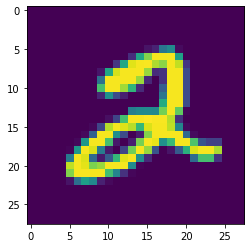

In [4]:
plt.imshow(images[5])

In [5]:
images = images/127.5 -1

In [6]:
images.min() , images.max()

(-1.0, 1.0)

In [7]:
images = np.expand_dims(images,-1)  #用tensorflow方法还要对数据进行转换

In [8]:
images.shape

(60000, 28, 28, 1)

In [9]:
 dataset = tf.data.Dataset.from_tensor_slices((images,labels))

In [10]:
dataset

<TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float64, tf.uint8)>

In [11]:
BATCH_SIZE = 256
noise_dim = 50


In [12]:
dataset = dataset.shuffle(60000).batch(BATCH_SIZE)

In [13]:
def generator():
    noise = layers.Input(shape=((noise_dim)))
    label = layers.Input(shape=(()))
    
    x = layers.Embedding(10,50,input_length=1)(label)
    x = layers.concatenate([seed,x])
    x = layers.Dense(3*3*128,use_bias=False)(x)
    x = layers.Reshape((3,3,128))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(64,(3,3), strides=(2,2),use_bias=False)(x)
    x = layers.BatchNormalization()(x)   #(7,7,,64)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(32,(3,3), strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)  #(14,14,32)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(1,(3,3), strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.Activation('tanh')(x)    #（28，28，1）
    
    model = tf.keras.Model(inputs=[seed,label], outputs = x)
    
    return model

In [14]:
gen = generator()
gen.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50)           500         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 100)          0           input_1[0][0]                    
                                                                 embedding[0][0]              

In [15]:
def discriminator():
    image = layers.Input(shape=(28,28,1))
    label = layers.Input(shape=(()))
    
    x = layers.Embedding(10,28*28,input_length=1)(label) #变成图像大小的向量方便变形成图像大小
    x = layers.Reshape((28,28,1))(x)
    x = layers.concatenate([x,image])
    
    x = layers.Conv2D(32,(3,3),strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(64,(3,3),strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(128,(3,3),strides=(2,2),padding='same',use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    
    out_logits = layers.Dense(1)(x)   #未进行激活
    
    model = tf.keras.Model(inputs=[image,label], outputs = out_logits)
    
    return model

In [16]:
disc = discriminator()
disc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 784)          7840        input_4[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_out,fake_out):
    
    #这里希望让真实图像被判定为1,假的图像判定为0
    real_loss = cross_entropy(tf.ones_like(real_out),real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out),fake_out)
    
    return real_loss + fake_loss

In [19]:
#生成器生成假的的图片并希望能够被判为真
def generator_loss(fake_out):
    return cross_entropy(tf.ones_like(fake_out),fake_out)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)   #创建优化器

In [21]:
@tf.function
def train_step(image,label):
    size = label.shape[0]
    noise = tf.random.normal([size,noise_dim])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
         
        gen_image = gen((noise,label),training=True)
        fake_out = disc((gen_image,label),training=True)
        real_out = disc((image,label),training=True)
         
        gen_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out,fake_out)
        
    gradient_gen = gen_tape.gradient(gen_loss,gen.trainable_variables)
    gradient_disc = disc_tape.gradient(disc_loss,disc.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_gen,gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_disc,disc.trainable_variables))
    

In [22]:
#画出这一个批次的图片
def generate_plot_image(model, noise, label,epoch_num):
    print('Epoch:',epoch_num)
    gen_image = model((noise,label),training=False)
    gen_image = tf.squeeze(gen_image)  #(28,28,1) -->(None,28,28)
    fig = plt.figure(figsize=(10,1))
    for i in range(gen_image.shape[0]):
        plt.subplot(1,10,i+1)   #1行10列
        #因为在生成图片最后用激活函数tanh把图片映射到[-1,1]之间,现在要把取值范围改变成[0,1]的范围
        plt.imshow((gen_image[i,:,:] + 1)/ 2)
        plt.axis('off')    #不用显示坐标
    plt.show()

In [23]:
num = 10
noise_seed = tf.random.normal([num,noise_dim])
label_seed = np.random.randint(0,10,size=(num,1))
print(label_seed.T)

[[5 1 2 6 6 0 3 5 6 0]]


In [24]:
def train(dataset,epochs):
    for epoch in range(epochs):
        for image_bath ,label_batch in dataset:
            train_step(image_bath,label_batch)
        if epoch%10 ==0:
            generate_plot_image(gen,noise_seed,label_seed,epoch)
    generate_plot_image(gen,noise_seed,label_seed,epoch)   
           

In [25]:
EPOCHES = 200

In [26]:
train(dataset,EPOCHES)

Epoch: 0


InvalidArgumentError: ConcatOp : Ranks of all input tensors should match: shape[0] = [10,50] vs. shape[1] = [10,1,50] [Op:ConcatV2] name: concat